# 2. CNN Models

## 2.1 Imports

In [ ]:
from google.colab import files, drive
import matplotlib.pyplot as plt
import sys
import os
import shutil
import numpy as np
import pickle, dill
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPool2D, Flatten, Dense, Dropout

## 2.2 Initialization

In [ ]:
#path to saved resources
saved_resources_path = '/content/gdrive/MyDrive/Capstone3/SavedResources'

#path to src folder
src_path = '/content/gdrive/MyDrive/Capstone3/src'

#mount google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#add the src folder to the search path so that modules in the src folder can be imported
sys.path.append(src_path)
import DataSetup
import BuildModels

The **DataSetup.py** script contains functions that are useful for preparing the dataset. This includes setting up the folder structure, performing the train/test split, and setting up the train and validation sets from the image directories. The **BuildModels.py** script contains functions to prepare the architecture for each model, compile and train the models, and plot model performance on training and validation sets.

In [ ]:
#load saved constants
with open(os.path.join(saved_resources_path, 'constants_dict.pkl' ), 'rb') as handle:
    constants_dict = pickle.load(handle)

constants_dict

{'CLASS_SIZE': 5000, 'IMAGE_SIZE': (768, 768), 'K': 5, 'RANDOM_SEED': 42}

In [ ]:
#set batch size
BATCH_SIZE = 32

In [ ]:
#load the mappings of image class to folder location for the raw dataset
with open(os.path.join(saved_resources_path, 'dict_original_image_paths.pkl' ), 'rb') as handle:
    dict_image_paths = pickle.load(handle)

dict_image_paths

{'colon_aca': 'lung_colon_image_set/colon_image_sets/colon_aca/',
 'colon_normal': 'lung_colon_image_set/colon_image_sets/colon_n/',
 'lung_aca': 'lung_colon_image_set/lung_image_sets/lung_aca/',
 'lung_normal': 'lung_colon_image_set/lung_image_sets/lung_n/',
 'lung_scc': 'lung_colon_image_set/lung_image_sets/lung_scc/'}

## 2.3 Load and Prepare Data

### 2.3.1 Upload API key to connect to kaggle

In [ ]:
#upload the API key (kaggle.json)
_ = files.upload()

Saving kaggle.json to kaggle.json


### 2.3.2 Download and Unzip the Dataset

In [ ]:
###download and unzip the lung and colon cancer image dataset using the saved function "dataset_setup"
with open(os.path.join(saved_resources_path,'dataset_setup_function.pkl'), 'rb') as file_in:
    dataset_setup = dill.loads(dill.load(file_in))

dataset_setup()

 99% 1.73G/1.76G [00:06<00:00, 289MB/s]
100% 1.76G/1.76G [00:06<00:00, 287MB/s]


### 2.3.3 Train/Test Split

**Setup train/test folders**

In [ ]:
###set up the folder structure for the train/test data using the saved function "folder_setup"

#image classes
image_classes = dict_image_paths.keys()

#function returns the folder paths for each image class in the train and test sets
train_test_path_dict = DataSetup.folder_setup(image_classes)

train_test_path_dict

{'test': {'data/test/colon_aca',
  'data/test/colon_normal',
  'data/test/lung_aca',
  'data/test/lung_normal',
  'data/test/lung_scc'},
 'train': {'data/train/colon_aca',
  'data/train/colon_normal',
  'data/train/lung_aca',
  'data/train/lung_normal',
  'data/train/lung_scc'}}

**Split the data into train/test sets**

In [ ]:
### split the data into train and test sets
DataSetup.train_test_split(saved_resources_path)

In [ ]:
##Ensure that there are no overlapping images in the train and test sets
##and that the train/test set sizes are correct
train_test_folders = ['data/train', 'data/test']

for img_class, path in dict_image_paths.items():
    train_path = os.path.join(train_test_folders[0],img_class)
    test_path = os.path.join(train_test_folders[1],img_class)

    train_set = set(os.listdir(train_path))
    test_set = set(os.listdir(test_path))

    #ensure no overlapping images
    assert len(train_set.intersection(test_set)) == 0

    #ensure the training and test set sizes are correct
    assert len(train_set) == constants_dict['CLASS_SIZE'] * 0.9
    assert len(test_set) ==  constants_dict['CLASS_SIZE'] * 0.1

## 2.4 Build Models

### 2.4.1 Baseline Model

**Build and train the model**

In [ ]:
###get the data

#random_state
random_state = constants_dict['RANDOM_SEED']

#image_size
image_size=(constants_dict['IMAGE_SIZE'][0]//2, constants_dict['IMAGE_SIZE'][1]//2)

#get train and validation sets
train_data, validation_data = \
    DataSetup.training_datasets_from_directory(random_state, image_size, BATCH_SIZE)

Found 22500 files belonging to 5 classes.
Using 20250 files for training.
Found 22500 files belonging to 5 classes.
Using 2250 files for validation.


In [ ]:
####build the baseline model

#input shape
input_shape = (BATCH_SIZE, constants_dict['IMAGE_SIZE'][0]//2, constants_dict['IMAGE_SIZE'][1]//2, 3)

#number of classes
K = constants_dict['K']

#build the baseline model
baseline_model = BuildModels.build_baseline_model(input_shape, K)

#set dtype policy to mixed_float16 for faster training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
###compile and fit the baseline CNN model
results = BuildModels.compile_fit_model(baseline_model, train_data, validation_data)

Epoch 1/100
633/633 [==============================] - 115s 160ms/step - loss: 0.8572 - accuracy: 0.6888 - val_loss: 0.4305 - val_accuracy: 0.8267
Epoch 2/100
633/633 [==============================] - 102s 161ms/step - loss: 0.4079 - accuracy: 0.8216 - val_loss: 0.3293 - val_accuracy: 0.8689
Epoch 3/100
633/633 [==============================] - 103s 161ms/step - loss: 0.2895 - accuracy: 0.8796 - val_loss: 0.2847 - val_accuracy: 0.8942
Epoch 4/100
633/633 [==============================] - 102s 161ms/step - loss: 0.1584 - accuracy: 0.9406 - val_loss: 0.2728 - val_accuracy: 0.9133
Epoch 5/100
633/633 [==============================] - 102s 161ms/step - loss: 0.0834 - accuracy: 0.9714 - val_loss: 0.3161 - val_accuracy: 0.8987
Epoch 6/100
633/633 [==============================] - 102s 161ms/step - loss: 0.0569 - accuracy: 0.9811 - val_loss: 0.3497 - val_accuracy: 0.9173
Epoch 7/100
633/633 [==============================] - 102s 160ms/step - loss: 0.0485 - accuracy: 0.9834 - val_loss: 0

**Plot loss and accuracy**

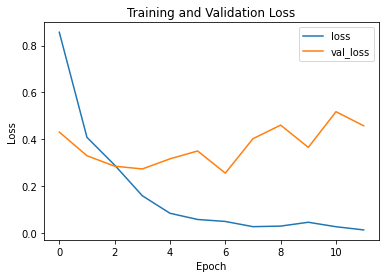

In [ ]:
#plot the loss
BuildModels.plot_loss(results)

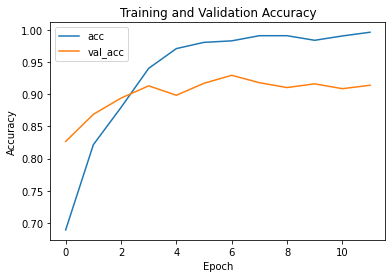

In [ ]:
#plot the accuracy
BuildModels.plot_accuracy(results)

**Save the model**

In [ ]:
###Save the baseline model 

#mount google drive
drive.mount('/content/gdrive')

#set the file path
filepath = '/content/gdrive/MyDrive/Capstone3/models/baseline/'

#create the folder if it does not exist
if not os.path.isdir(filepath):
    os.mkdir(filepath)

#save the model weights
baseline_model.save_weights(os.path.join(filepath,'baseline_model_weights'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Baseline Model Analysis**

* The baseline model's best performance was 92.98% accuracy on the validation set. The model trained for 12 epochs meaning that the model performed best on epoch 7 (since early stopping with a patience of 5 was used). The best version of the model was saved.
* The baseline model performed best after training for only 7 epochs. It is possible that the model was able to extract the underlying signal in the data very quickly. However, it may be worth using strategies to reduce the rate at which the model overfits during training. This may provide more of an opportunity to identify useful features/patterns during training. Two strategies that may be useful are adding **dropout layers** to the baseline model and including **data augmentation** as a preprocessing step.

### 2.4.2 Dropout Model

**Build and train the model**

In [ ]:
###get the data

#random_state
random_state = constants_dict['RANDOM_SEED']

#image_size
image_size=(constants_dict['IMAGE_SIZE'][0]//2, constants_dict['IMAGE_SIZE'][1]//2)

#get train and validation sets
train_data, validation_data = \
    DataSetup.training_datasets_from_directory(random_state, image_size, BATCH_SIZE)

Found 22500 files belonging to 5 classes.
Using 20250 files for training.
Found 22500 files belonging to 5 classes.
Using 2250 files for validation.


In [ ]:
###build the dropout model

#input shape
input_shape = (BATCH_SIZE, constants_dict['IMAGE_SIZE'][0]//2, constants_dict['IMAGE_SIZE'][1]//2, 3)

#number of classes
K = constants_dict['K']

#build the dropout model
dropout_model = BuildModels.build_dropout_model(input_shape, K)

#set dtype policy to mixed_float16 for faster training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [ ]:
###compile and fit the dropout model
results = BuildModels.compile_fit_model(dropout_model, train_data, validation_data)

Epoch 1/100
633/633 [==============================] - 152s 233ms/step - loss: 1.0399 - accuracy: 0.7000 - val_loss: 0.5377 - val_accuracy: 0.7778
Epoch 2/100
633/633 [==============================] - 140s 220ms/step - loss: 0.4097 - accuracy: 0.8259 - val_loss: 0.3143 - val_accuracy: 0.8902
Epoch 3/100
633/633 [==============================] - 137s 215ms/step - loss: 0.3009 - accuracy: 0.8775 - val_loss: 0.3842 - val_accuracy: 0.8231
Epoch 4/100
633/633 [==============================] - 135s 212ms/step - loss: 0.2211 - accuracy: 0.9119 - val_loss: 0.2568 - val_accuracy: 0.9009
Epoch 5/100
633/633 [==============================] - 134s 211ms/step - loss: 0.1653 - accuracy: 0.9377 - val_loss: 0.3332 - val_accuracy: 0.8742
Epoch 6/100
633/633 [==============================] - 133s 210ms/step - loss: 0.1258 - accuracy: 0.9542 - val_loss: 0.7488 - val_accuracy: 0.7618
Epoch 7/100
633/633 [==============================] - 134s 210ms/step - loss: 0.1036 - accuracy: 0.9635 - val_loss: 0

**Plot loss and accuracy**

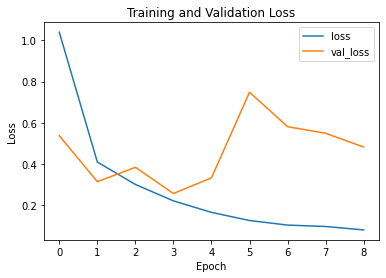

In [ ]:
#plot the loss
BuildModels.plot_loss(results)

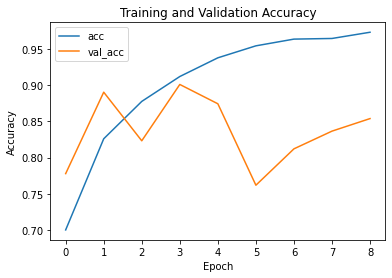

In [ ]:
#plot the accuracy
BuildModels.plot_accuracy(results)

**Save the model**

In [ ]:
###Save the dropout model 

#mount google drive
drive.mount('/content/gdrive')

#set the file path
filepath = '/content/gdrive/MyDrive/Capstone3/models/dropout'

#create the folder if it does not exist
if not os.path.isdir(filepath):
    os.mkdir(filepath)

#save the model weights
dropout_model.save_weights(os.path.join(filepath,'dropout_model_weights'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Dropout Model Analysis**

* The dropout model's best performance was 90.09% accuracy on the validation set. The model trained for 9 epochs meaning that the model performed best on epoch 4 (since early stopping with a patience of 5 was used). The best version of the model was saved.
* Dropout layers were used in an attempt to improve upon the baseline model, as the baseline model appeared to overfit fairly quickly during training. However, the dropout model actually appeared to overfit more quickly than the baseline model. Also, the best dropout model did not perform as well on the validation set compared to the best baseline model. It is possible that the dropout layers actually impaired the model's ability to extract useful patterns from the data during training.

### 2.4.3 Model with Data Augmentation 

**Build and train the model**

In [ ]:
###get the data

#random_state
random_state = constants_dict['RANDOM_SEED']

#image_size
image_size=(constants_dict['IMAGE_SIZE'][0]//2, constants_dict['IMAGE_SIZE'][1]//2)

#get train and validation sets
train_data, validation_data = \
    DataSetup.training_datasets_from_directory(random_state, image_size, BATCH_SIZE)

Found 22500 files belonging to 5 classes.
Using 20250 files for training.
Found 22500 files belonging to 5 classes.
Using 2250 files for validation.


In [ ]:
###build the data augmentation model

#input shape
input_shape = (BATCH_SIZE, constants_dict['IMAGE_SIZE'][0]//2, constants_dict['IMAGE_SIZE'][1]//2, 3)

#number of classes
K = constants_dict['K']

#random state
random_state = constants_dict['RANDOM_SEED']

#build the data augmentation model
data_augmentation_model = BuildModels.build_data_augmentation_model(input_shape, K, random_state)

#set dtype policy to mixed_float16 for faster training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [ ]:
###compile and fit the data augmentation model
results = BuildModels.compile_fit_model(data_augmentation_model, train_data, validation_data)

Epoch 1/100
633/633 [==============================] - 139s 215ms/step - loss: 0.7898 - accuracy: 0.7163 - val_loss: 0.4599 - val_accuracy: 0.7738
Epoch 2/100
633/633 [==============================] - 131s 207ms/step - loss: 0.4712 - accuracy: 0.7952 - val_loss: 0.4208 - val_accuracy: 0.8142
Epoch 3/100
633/633 [==============================] - 128s 201ms/step - loss: 0.4094 - accuracy: 0.8299 - val_loss: 0.3051 - val_accuracy: 0.8702
Epoch 4/100
633/633 [==============================] - 127s 200ms/step - loss: 0.3366 - accuracy: 0.8613 - val_loss: 0.3937 - val_accuracy: 0.8151
Epoch 5/100
633/633 [==============================] - 126s 198ms/step - loss: 0.3207 - accuracy: 0.8661 - val_loss: 0.2664 - val_accuracy: 0.8831
Epoch 6/100
633/633 [==============================] - 122s 192ms/step - loss: 0.2805 - accuracy: 0.8880 - val_loss: 0.2019 - val_accuracy: 0.9164
Epoch 7/100
633/633 [==============================] - 121s 190ms/step - loss: 0.2701 - accuracy: 0.8901 - val_loss: 0

**Plot loss and accuracy**

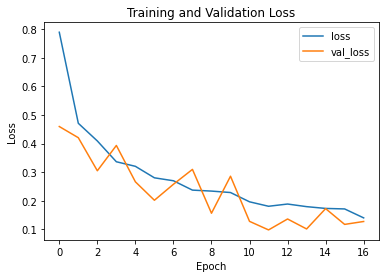

In [ ]:
#plot the loss
BuildModels.plot_loss(results)

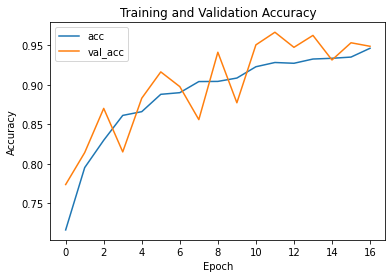

In [ ]:
#plot the accuracy
BuildModels.plot_accuracy(results)

**Save the model**

In [ ]:
###Save the data augmentation model 

#mount google drive
drive.mount('/content/gdrive')

#set the file path
filepath = '/content/gdrive/MyDrive/Capstone3/models/data_augmentation'

#create the folder if it does not exist
if not os.path.isdir(filepath):
    os.mkdir(filepath)

#save the model weights
data_augmentation_model.save_weights(os.path.join(filepath,'data_augmentation_model_weights'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Data Augmentation Model Analysis**

* The data augmentation model's best performance was 96.67% accuracy on the validation set. The model trained for 17 epochs meaning that the model performed best on epoch 12 (since early stopping with a patience of 5 was used). The best version of the model was saved.
* Data augmentation as a preprocessing step was used in an attempt to improve upon the baseline model. It appears that increasing the number of training examples, and the variability among the training examples, reduced the rate at which the model overfit during training. The performance of the model, compared to the baseline, also improved. This is not surprising because data augmentation provides the model with more training data. Therefore, the model would be expected to have more of an opportunity to extract useful patterns from the data during training. Based on the the model's performance on validation data, data augmentation appears to be a useful technique for improving upon the baseline model. 

### 2.4.4 Deeper CNN (More Convolutional Layers)

**Build and train the model**

In [ ]:
###get the data

#random_state
random_state = constants_dict['RANDOM_SEED']

#image_size
image_size=(constants_dict['IMAGE_SIZE'][0]//2, constants_dict['IMAGE_SIZE'][1]//2)

#get train and validation sets
train_data, validation_data = \
    DataSetup.training_datasets_from_directory(random_state, image_size, BATCH_SIZE)

Found 22500 files belonging to 5 classes.
Using 20250 files for training.
Found 22500 files belonging to 5 classes.
Using 2250 files for validation.


In [ ]:
###build the deeper CNN model

#input shape
input_shape = (BATCH_SIZE, constants_dict['IMAGE_SIZE'][0]//2, constants_dict['IMAGE_SIZE'][1]//2, 3)

#number of classes
K = constants_dict['K']

#build the deep CNN model
deep_model = BuildModels.build_deep_model(input_shape, K)

#set dtype policy to mixed_float16 for faster training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [ ]:
###compile and fit the deep model
results = BuildModels.compile_fit_model(deep_model, train_data, validation_data)

Epoch 1/100
633/633 [==============================] - 241s 358ms/step - loss: 0.9034 - accuracy: 0.7373 - val_loss: 0.3621 - val_accuracy: 0.8413
Epoch 2/100
633/633 [==============================] - 212s 334ms/step - loss: 0.3181 - accuracy: 0.8695 - val_loss: 0.2491 - val_accuracy: 0.9053
Epoch 3/100
633/633 [==============================] - 209s 330ms/step - loss: 0.2089 - accuracy: 0.9195 - val_loss: 0.3434 - val_accuracy: 0.8653
Epoch 4/100
633/633 [==============================] - 209s 330ms/step - loss: 0.1193 - accuracy: 0.9561 - val_loss: 0.4023 - val_accuracy: 0.8724
Epoch 5/100
633/633 [==============================] - 208s 328ms/step - loss: 0.0773 - accuracy: 0.9722 - val_loss: 0.3195 - val_accuracy: 0.9164
Epoch 6/100
633/633 [==============================] - 208s 328ms/step - loss: 0.0513 - accuracy: 0.9840 - val_loss: 0.5117 - val_accuracy: 0.8844
Epoch 7/100
633/633 [==============================] - 207s 327ms/step - loss: 0.0446 - accuracy: 0.9854 - val_loss: 0

**Plot loss and accuracy**

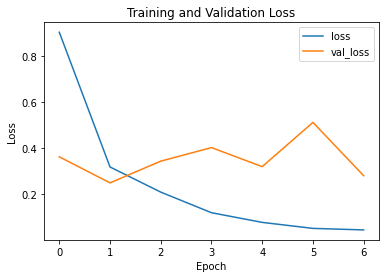

In [ ]:
#plot the loss
BuildModels.plot_loss(results)

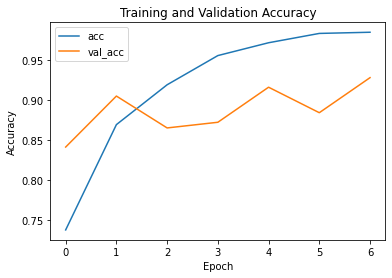

In [ ]:
#plot the accuracy
BuildModels.plot_accuracy(results)

**Save the model**

In [ ]:
###Save the deep model 

#mount google drive
drive.mount('/content/gdrive')

#set the file path
filepath = '/content/gdrive/MyDrive/Capstone3/models/deep'

#create the folder if it does not exist
if not os.path.isdir(filepath):
    os.mkdir(filepath)

#save the model weights
deep_model.save_weights(os.path.join(filepath,'deep_model_weights'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Deep CNN Model Analysis**

* The deep CNN model's best performance was 92.84% accuracy on the validation set. However, the model's best performance in terms of loss came on the second epoch where it achieved a validation accuracy of 90.53%.
* A deeper CNN model was trained because in some cases adding more layers can help a model identify more complex features. However, more layers can also lead to models that overfit quickly. In this case, adding depth to the model did not appear to help. The best performing version of the model was trained after only 2 epochs. Additionally, the best deep CNN model did not perform as well as the best baseline model on the validation data. However, it is possible that using data augmentation to provide the deeper model with more data could help reduce the rate of overfitting and allow the deeper model to extract more useful features.

### 2.4.5 Deep Model with Data Augmentation

**Build and train the model**

In [ ]:
###get the data

#random_state
random_state = constants_dict['RANDOM_SEED']

#image_size
image_size=(constants_dict['IMAGE_SIZE'][0]//2, constants_dict['IMAGE_SIZE'][1]//2)

#get train and validation sets
train_data, validation_data = \
    DataSetup.training_datasets_from_directory(random_state, image_size, BATCH_SIZE)

Found 22500 files belonging to 5 classes.
Using 20250 files for training.
Found 22500 files belonging to 5 classes.
Using 2250 files for validation.


In [ ]:
###build the deep augmentation model

#input shape
input_shape = (BATCH_SIZE, constants_dict['IMAGE_SIZE'][0]//2, constants_dict['IMAGE_SIZE'][1]//2, 3)

#number of classes
K = constants_dict['K']

#random state
random_state = constants_dict['RANDOM_SEED']

#build the deep augmentation model
deep_augmented_model = BuildModels.build_deep_augmented_model(input_shape, K, random_state)

#set dtype policy to mixed_float16 for faster training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [ ]:
###compile and fit the deep augmented model
results = BuildModels.compile_fit_model(deep_augmented_model, train_data, validation_data)

Epoch 1/100
633/633 [==============================] - 226s 353ms/step - loss: 0.8758 - accuracy: 0.7084 - val_loss: 0.4127 - val_accuracy: 0.8302
Epoch 2/100
633/633 [==============================] - 219s 345ms/step - loss: 0.4240 - accuracy: 0.8121 - val_loss: 0.4263 - val_accuracy: 0.8302
Epoch 3/100
633/633 [==============================] - 218s 344ms/step - loss: 0.3835 - accuracy: 0.8347 - val_loss: 0.3328 - val_accuracy: 0.8649
Epoch 4/100
633/633 [==============================] - 218s 343ms/step - loss: 0.3247 - accuracy: 0.8657 - val_loss: 0.2534 - val_accuracy: 0.8942
Epoch 5/100
633/633 [==============================] - 217s 342ms/step - loss: 0.2934 - accuracy: 0.8805 - val_loss: 0.2337 - val_accuracy: 0.9076
Epoch 6/100
633/633 [==============================] - 216s 341ms/step - loss: 0.2497 - accuracy: 0.9012 - val_loss: 0.2320 - val_accuracy: 0.9044
Epoch 7/100
633/633 [==============================] - 216s 340ms/step - loss: 0.2199 - accuracy: 0.9125 - val_loss: 0

**Plot loss and accuracy**

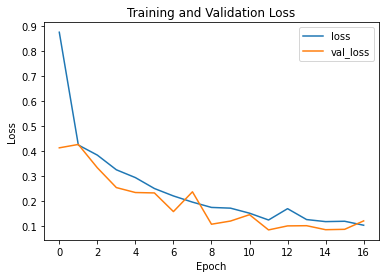

In [ ]:
#plot the loss
BuildModels.plot_loss(results)

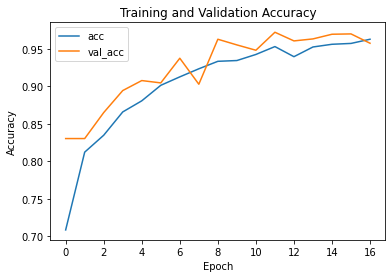

In [ ]:
#plot the accuracy
BuildModels.plot_accuracy(results)

**Save the model**

In [ ]:
###Save the deep augmentation model 

#mount google drive
drive.mount('/content/gdrive')

#set the file path
filepath = '/content/gdrive/MyDrive/Capstone3/models/deep_augmentation'

#create the folder if it does not exist
if not os.path.isdir(filepath):
    os.mkdir(filepath)

#save the model weights
deep_augmented_model.save_weights(os.path.join(filepath,'deep_augmented_model_weights'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Deep Model with Data Augmentation Analysis**

* The deep CNN with data augmentation model's best performance was 97.20% accuracy on the validation set. The model trained for 17 epochs meaning that the model performed best on epoch 12 (since early stopping with a patience of 5 was used). The best version of the model was saved.
* The first deep CNN model performed poorly on the validation set. However, data augmentation when training the deep CNN model was tested. Data augmentation appeared to work well when training the baseline model and it was thought that the deep CNN model was also likely to benefit from more training data. The additional data provided by data augmentation appeared to drastically improve the deep CNN model's ability to extract useful features, while reducing the rate of overfitting. The deep CNN with data augmentation was the best performing non-transfer learning model on the validation set. The model's performance also appeared to be stable as it leveled off without much variation during the final training epochs. 